In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import dot, multiply, diag, power
from numpy import pi, exp, sin, cos
from numpy.linalg import inv, eig, pinv, solve
from scipy.linalg import svd, svdvals
from math import floor, ceil # python 3.x

import scipy.io

import matplotlib.pyplot as plt
import numpy as np
import scipy
import math

from sklearn.metrics import mean_squared_error
#from pydmd.plotter import plot_eigs

import numpy as np
import matplotlib.pyplot as plt
from numpy import dot, multiply, diag, power
from numpy import pi, exp, sin, cos
from numpy.linalg import inv, eig, pinv, solve
from scipy.linalg import svd, svdvals
from math import floor, ceil # python 3.x

import scipy.io

#from pydmd import dmdc

"""
Derived module from dmdbase.py for dmd with control.

Reference:
- Proctor, J.L., Brunton, S.L. and Kutz, J.N., 2016. Dynamic mode decomposition
with control. SIAM Journal on Applied Dynamical Systems, 15(1), pp.142-161.
"""
import numpy as np

from pydmd.dmdbase import DMDBase
from pydmd.dmdoperator import DMDOperator
from pydmd.snapshots import Snapshots
from pydmd.utils import compute_svd, compute_tlsq


class DMDControlOperator(DMDOperator):
    """
    DMD with control base operator. This should be subclassed in order to
    implement the appropriate features.

    :param svd_rank: the rank for the truncation; If 0, the method computes the
        optimal rank and uses it for truncation; if positive interger, the
        method uses the argument for the truncation; if float between 0 and 1,
        the rank is the number of the biggest singular values that are needed
        to reach the 'energy' specified by `svd_rank`; if -1, the method does
        not compute truncation.
    :type svd_rank: int or float
    :param svd_rank_omega: the rank for the truncation of the aumented matrix
        omega composed by the left snapshots matrix and the control. Used only
        for the `_fit_B_unknown` method of this class. It should be greater or
        equal than `svd_rank`. For the possible values please refer to the
        `svd_rank` parameter description above.
    :type svd_rank_omega: int or float
    :param int tlsq_rank: rank truncation computing Total Least Square. Default
        is 0, that means no truncation.
    """

    def __init__(self, svd_rank, svd_rank_omega, tlsq_rank):
        super(DMDControlOperator, self).__init__(
            svd_rank=svd_rank,
            exact=True,
            rescale_mode=None,
            forward_backward=False,
            sorted_eigs=False,
            tikhonov_regularization=None,
        )
        self._svd_rank_omega = svd_rank_omega
        self._tlsq_rank = tlsq_rank


class DMDBKnownOperator(DMDControlOperator):
    """
    DMD with control base operator when B is given.

    :param svd_rank: the rank for the truncation; If 0, the method computes the
        optimal rank and uses it for truncation; if positive interger, the
        method uses the argument for the truncation; if float between 0 and 1,
        the rank is the number of the biggest singular values that are needed
        to reach the 'energy' specified by `svd_rank`; if -1, the method does
        not compute truncation.
    :type svd_rank: int or float
    :param svd_rank_omega: the rank for the truncation of the aumented matrix
        omega composed by the left snapshots matrix and the control. Used only
        for the `_fit_B_unknown` method of this class. It should be greater or
        equal than `svd_rank`. For the possible values please refer to the
        `svd_rank` parameter description above.
    :type svd_rank_omega: int or float
    :param int tlsq_rank: rank truncation computing Total Least Square. Default
        is 0, that means no truncation.
    """

    def compute_operator(self, X, Y, B, controlin):
        """
        Compute the low-rank operator. This is the standard version of the DMD
        operator, with a correction which depends on B.

        :param numpy.ndarray X: matrix containing the snapshots x0,..x{n-1} by
            column.
        :param numpy.ndarray Y: matrix containing the snapshots x1,..x{n} by
            column.
        :param numpy.ndarray B: the matrix B.
        :param numpy.ndarray control: the control input.
        :return: the (truncated) left-singular vectors matrix, the (truncated)
            singular values array, the (truncated) right-singular vectors
            matrix of X.
        :rtype: numpy.ndarray, numpy.ndarray, numpy.ndarray
        """
        X, Y = compute_tlsq(X, Y, self._tlsq_rank)
        Y = Y - B.dot(controlin)
        return super(DMDBKnownOperator, self).compute_operator(X, Y)


class DMDBUnknownOperator(DMDControlOperator):
    """
    DMD with control base operator when B is unknown.

    :param svd_rank: the rank for the truncation; If 0, the method computes the
        optimal rank and uses it for truncation; if positive interger, the
        method uses the argument for the truncation; if float between 0 and 1,
        the rank is the number of the biggest singular values that are needed
        to reach the 'energy' specified by `svd_rank`; if -1, the method does
        not compute truncation.
    :type svd_rank: int or float
    :param svd_rank_omega: the rank for the truncation of the aumented matrix
        omega composed by the left snapshots matrix and the control. Used only
        for the `_fit_B_unknown` method of this class. It should be greater or
        equal than `svd_rank`. For the possible values please refer to the
        `svd_rank` parameter description above.
    :type svd_rank_omega: int or float
    :param int tlsq_rank: rank truncation computing Total Least Square. Default
        is 0, that means no truncation.
    """

    def compute_operator(self, X, Y, controlin):
        """
        Compute the low-rank operator.

        :param numpy.ndarray X: matrix containing the snapshots x0,..x{n-1} by
            column.
        :param numpy.ndarray Y: matrix containing the snapshots x1,..x{n} by
            column.
        :param numpy.ndarray control: the control input.
        :return: the (truncated) left-singular vectors matrix of Y, and
            the product between the left-singular vectors of Y and Btilde.
        :rtype: numpy.ndarray, numpy.ndarray
        """
        snapshots_rows = X.shape[0]

        omega = np.vstack([X, controlin])

        Up, sp, Vp = compute_svd(omega, self._svd_rank_omega)

        Up1 = Up[:snapshots_rows, :]
        Up2 = Up[snapshots_rows:, :]

        Ur, _, _ = compute_svd(Y, self._svd_rank)

        self._Atilde = np.linalg.multi_dot(
            [Ur.T.conj(), Y, Vp, np.diag(np.reciprocal(sp)), Up1.T.conj(), Ur]
        )
        self._compute_eigenquantities()
        self._compute_modes(Y, sp, Vp, Up1, Ur)

        Btilde = np.linalg.multi_dot(
            [Ur.T.conj(), Y, Vp, np.diag(np.reciprocal(sp)), Up2.T.conj()]
        )

        return Ur, Ur.dot(Btilde)

    def _compute_modes(self, Y, sp, Vp, Up1, Ur):
        """
        Private method that computes eigenvalues and eigenvectors of the
        high-dimensional operator (stored in self.modes and self.Lambda).
        """

        self._modes = np.linalg.multi_dot(
            [
                Y,
                Vp,
                np.diag(np.reciprocal(sp)),
                Up1.T.conj(),
                Ur,
                self.eigenvectors,
            ]
        )
        self._Lambda = self.eigenvalues


class DMDc(DMDBase):
    """
    Dynamic Mode Decomposition with control.
    This version does not allow to manipulate the temporal window within the
    system is reconstructed.

    :param svd_rank: the rank for the truncation; If 0, the method computes the
        optimal rank and uses it for truncation; if positive interger, the
        method uses the argument for the truncation; if float between 0 and 1,
        the rank is the number of the biggest singular values that are needed
        to reach the 'energy' specified by `svd_rank`; if -1, the method does
        not compute truncation.
    :type svd_rank: int or float
    :param int tlsq_rank: rank truncation computing Total Least Square. Default
        is 0, that means no truncation.
    :param opt: argument to control the computation of DMD modes amplitudes.
        See :class:`DMDBase`. Default is False.
    :type opt: bool or int
    :param svd_rank_omega: the rank for the truncation of the aumented matrix
        omega composed by the left snapshots matrix and the control. Used only
        for the `_fit_B_unknown` method of this class. It should be greater or
        equal than `svd_rank`. For the possible values please refer to the
        `svd_rank` parameter description above.
    :type svd_rank_omega: int or float
    """

    def __init__(self, svd_rank=0, tlsq_rank=0, opt=False, svd_rank_omega=-1):
        # we're going to initialize Atilde when we know if B is known
        self._Atilde = None
        # remember the arguments for when we'll need them
        self._dmd_operator_kwargs = {
            "svd_rank": svd_rank,
            "svd_rank_omega": svd_rank_omega,
            "tlsq_rank": tlsq_rank,
        }

        self._opt = opt
        self._exact = False

        self._B = None
        self._snapshots_holder = None
        self._controlin = None
        self._basis = None

        self._modes_activation_bitmask_proxy = None

        self.level = None            # level of recursion
        self.bin_num = None        # time bin number
        self.bin_size = None      # time bin size
        self.start = None          # starting index
        self.stop = None # stopping index
        self.step = None              # step size
        self.dato = None

    @property
    def svd_rank_omega(self):
        return self.operator._svd_rank_omega

    @property
    def B(self):
        """
        Get the operator B.

        :return: the operator B.
        :rtype: numpy.ndarray
        """
        return self._B

    @property
    def basis(self):
        """
        Get the basis used to reduce the linear operator to the low dimensional
        space.

        :return: the matrix which columns are the basis vectors.
        :rtype: numpy.ndarray
        """
        return self._basis


    
    
    def reconstructed_data(self, control_input=None):
        """
        Return the reconstructed data, computed using the `control_input`
        argument. If the `control_input` is not passed, the original input (in
        the `fit` method) is used. The input dimension has to be consistent
        with the dynamics.

        :param numpy.ndarray control_input: the input control matrix.
        :return: the matrix that contains the reconstructed snapshots.
        :rtype: numpy.ndarray
        """
        controlin = (
            np.asarray(control_input)
            if control_input is not None
            else self._controlin
        )

        if controlin.shape[-1] != self.dynamics.shape[-1] - 1:                  #controlin 200x8
            raise RuntimeError(
                "The number of control inputs and the number of snapshots to "
                "reconstruct has to be the same"
            )
                                                                                #bin_size / step
        eigs = np.power(                                                         #eigs vettore di dimensione 8 per livello 0
            self.eigs, self.dmd_time["dt"] // self.original_time["dt"]
        )
        A = np.linalg.multi_dot(                                                  #A è una matrice 40x40 per livello 0
            [self.modes, np.diag(eigs), np.linalg.pinv(self.modes)]    
        )

        data = [self.snapshots[:, 0]]
        expected_shape = data[0].shape

        for i, u in enumerate(controlin.T):
            arr = A.dot(data[i]) + self._B.dot(u)
            if arr.shape != expected_shape:
                raise ValueError(
                    f"Invalid shape: expected {expected_shape}, got {arr.shape}"
                )
            data.append(arr)

        data = np.array(data).T

        return data
    
    '''
    def reconstructed_data_test(self, data = None, control_input=None):
    
       
        Return the reconstructed data, computed using the `control_input`
        argument. If the `control_input` is not passed, the original input (in
        the `fit` method) is used. The input dimension has to be consistent
        with the dynamics.

        :param numpy.ndarray control_input: the input control matrix.
        :return: the matrix that contains the reconstructed snapshots.
        :rtype: numpy.ndarray
       
        controlin = (
            np.asarray(control_input)
            if control_input is not None
            else self._controlin
        )
       
        if controlin.shape[-1] != self.dynamics.shape[-1] - 1:
            raise RuntimeError(
                "The number of control inputs and the number of snapshots to "
                "reconstruct has to be the same"
            )
    
        eigs = np.power(
            self.eigs, self.dmd_time["dt"] // self.original_time["dt"]
        )
        A = np.linalg.multi_dot(
            [self.modes, np.diag(eigs), np.linalg.pinv(self.modes)]    
        )

        
        if data is not None:
            None
        else: 
            data = [self.snapshots[:, 0]]
        
        expected_shape = data[0].shape

        for i in range(0,controlin.shape[0]):
            u = i
            arr = A.dot(data[i]) + self._B.dot(u)
            
            if arr.shape != expected_shape:
                raise ValueError(
                    f"Invalid shape: expected {expected_shape}, got {arr.shape}"
                )
               
            
            data = np.hstack(arr)

        
        #data = np.vstack([data, self.snapshots[:,0]])
        #data = data.T
            
        return data
        '''
    


    def fit(self, X, I, B=None):
        """
        Compute the Dynamic Modes Decomposition with control given the original
        snapshots and the control input data. The matrix `B` that controls how
        the control input influences the system evolution can be provided by
        the user; otherwise, it is computed by the algorithm.

        :param X: the input snapshots.
        :type X: numpy.ndarray or iterable
        :param I: the control input.
        :type I: numpy.ndarray or iterable
        :param numpy.ndarray B: matrix that controls the control input
            influences the system evolution.
        :type B: numpy.ndarray or iterable
        """
        self._reset()

        self._snapshots_holder = Snapshots(X)
        self._controlin = np.atleast_2d(np.asarray(I))

        n_samples = self.snapshots.shape[1]
        X = self.snapshots[:, :-1]
        Y = self.snapshots[:, 1:]

        self._set_initial_time_dictionary(
            {"t0": 0, "tend": n_samples - 1, "dt": 1}
        )

        if B is None:
            self._Atilde = DMDBUnknownOperator(**self._dmd_operator_kwargs)
            self._basis, self._B = self.operator.compute_operator(
                X, Y, self._controlin
            )
        else:
            self._Atilde = DMDBKnownOperator(**self._dmd_operator_kwargs)
            U, _, _ = self.operator.compute_operator(X, Y, B, self._controlin)

            self._basis = U
            self._B = B

        self._b = self._compute_amplitudes()

        return self




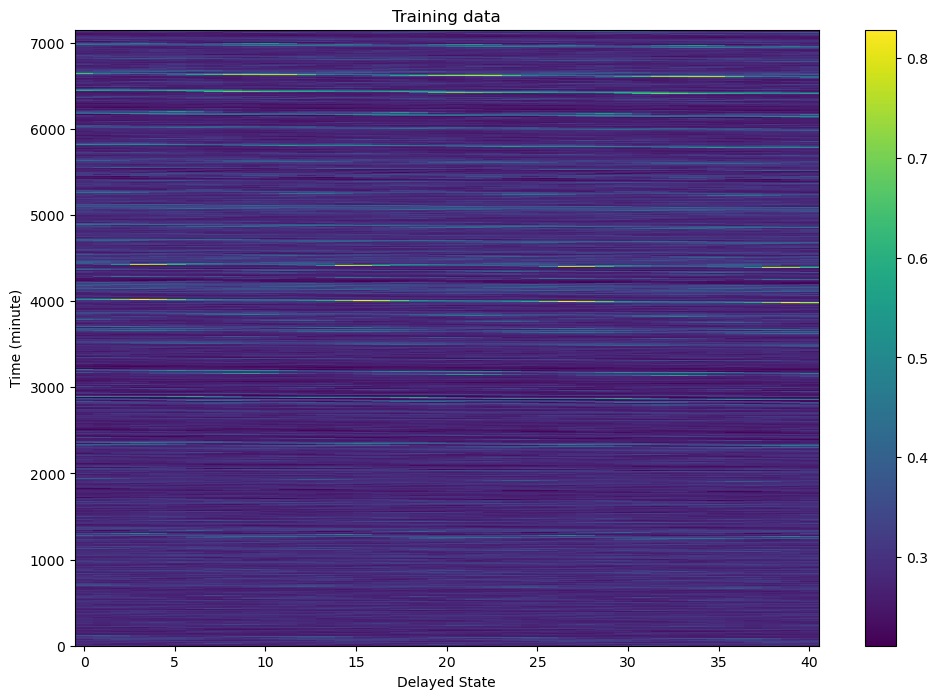

In [2]:


## Scelta del dataset, se a valori complessi o reali
#D_mat = scipy.io.loadmat('real_eig_timeseries.mat')
#D_mat = scipy.io.loadmat('complex_eig_timeseries.mat')
D_mat = scipy.io.loadmat('XU_DMDc.mat')

## Trasformo il formato .mat in un Numpy Array
## Cambiare l'argomento di D_mat['xt'] in D_mat['X'] se si usa il dataset XU_DMDc.mat
D_mat_list = [[element for element in upperElement] for upperElement in D_mat['X']]
U_mat_list = [[element for element in upperElement] for upperElement in D_mat['U']]
D = np.array(D_mat_list)
U = np.array(U_mat_list)


row_tot = D.shape[0]
column_tot = D.shape[1]


training_mode = 0.999


column_train = int(column_tot * training_mode)

# training mod
D_train = D[:,:int((training_mode*column_tot))]
U_train = U[:,:int(training_mode*column_tot)]

# testing mod
D_test = D[:,D_train.shape[1]:]
U_test = U[:,U_train.shape[1]:]
#for the testing mode we take che rest of array that remain from the division for the training 



x_train = np.linspace(0, row_tot, row_tot)
dt = 1    #1 minuto
t_train = np.linspace(0, int(dt * column_train), int(dt * column_train))








def make_plot(X, x=None, y=None, figsize=(12, 8), title=''):
    """
    Plot of the data X
    """
    plt.figure(figsize=figsize)
    plt.title(title)
    X = np.real(X)
    CS = plt.pcolor(x, y, X)
    cbar = plt.colorbar(CS)
    plt.xlabel('Delayed State')
    plt.ylabel('Time (minute)')
    plt.show()


make_plot(D_train.T, x=x_train, y=t_train, title = 'Training data')









def mrdmdc(D, U, level=0, bin_num=0, offset=0, max_levels=20, max_cycles=1):
    """Compute the multi-resolution DMD on the dataset `D`, returning a list of nodes
    in the hierarchy. Each node represents a particular "time bin" (window in time) at
    a particular "level" of the recursion (time scale). The node is an object consisting
    of the various data structures generated by the DMD at its corresponding level and
    time bin. The `level`, `bin_num`, and `offset` parameters are for record keeping 
    during the recursion and should not be modified unless you know what you are doing.
    The `max_levels` parameter controls the maximum number of levels. The `max_cycles`
    parameter controls the maximum number of mode oscillations in any given time scale 
    that qualify as "slow". The `do_svht` parameter indicates whether or not to perform
    optimal singular value hard thresholding."""
     
    
    # 4 times nyquist limit to capture cycles                 ## per il teorema di nyquist, un segnale sinusoidale puo'
                                                              ## essere ricostruito senza perdere informazioni, fintanto che 
                                                              ## viene campionato ad una frequenza due volte o piu' maggiori
                                                              ## della frequenza massima. (valore tipico: 4 volte maggiori)
                
    nyq = 4 * max_cycles                                      ## nyq = 8 * 2

    

    bin_size = D.shape[1]                          ## bin_size equivale al numero di colonne (1600)


    if (bin_size) < (nyq):                                        ## bin_size(1600)<nyq(16)
        return []

    # extract subsamples 
    step = floor(bin_size / nyq) # max step size to capture cycles   ## floor è una funzione che approssima per difetto
                                                                     ## esempio floor(2.9) equivale a 2.
                                                                     ## in questo caso bin_size / nyq == 100 , quindi step=100
            
    _D = D[:,::(step)]                                           ## D[:,:] è uno slice assignment, in particolare D[:,::step]
                                                             ## considera i valori presi ogni step di tutte le righe e crea
                                                               ## una nuova matrice con solo i valori considerati.
    _U = U[:,::(step)]
    
    D0 = _D[:,:]
    U0 = _U[:,1:]   #DA CONTROLLARE SE FARE U[:,:-1]

    dmdc = DMDc(svd_rank=-1) 

    dmdc.fit(D0,U0)
    

    '''
    mu = dmdc0.eigs
    Phi = dmdc0.modes

    parte per la filtrazione degli slow
    rho = max_cycles / bin_size                                ## frequenza di taglio rho definita come n° max di modi dinamici
                                                               ## classificati come "slow" diviso il numero di colonne della
                                                               ## matrice D.  2/1600=0.00125

    # consolidate slow eigenvalues (as boolean mask)
    slow = (np.abs(np.log(mu) / (2 * pi * step))) <= rho       ## ritorna il valore assoluto [abs()] del logaritmo di mu diviso
                                                               ## 2*pi greco*step, che deve essere minore o uguale a rho.
                                                               ## in questo caso [false false false false true true false]
        
    n = sum(slow) # number of slow modes                       ## il numero dei modi "slow" è dato dalla somma di slow.
                                                               ## in questo caso 2.

    # extract slow modes (perhaps empty)                       ## si estrae i modi "slow"
    dmdc0.__setattr__('eigs', mu[slow])                                               ## in mu salva solo gli autovalori "slow"
                                                               ## da 7 autovalori a 2 autovalori.

   
    dmdc0.modes = Phi[:,slow]                                          ## in phi salva solo i modi dinamici "slow"
                                                               ## phi.shape era (80,7) adesso è (80,2).
    '''
                                                               

    dato = dmdc.reconstructed_data()




    #node = type('Node', (object,), {})()
    dmdc.level = level            # level of recursion
    dmdc.bin_num = bin_num        # time bin number
    dmdc.bin_size = bin_size      # time bin size
    dmdc.start = offset           # starting index
    dmdc.stop = offset + bin_size # stopping index
    dmdc.step = step              # step size
    dmdc.dato = dato

    '''
    node.mu = dmdc0.eigs
    node.phi = dmdc0.modes
    node.A = dmdc0._Atilde
    node.B = dmdc0.B
    node._B = dmdc0._B
    node.psi = dmdc0.dynamics
    '''


    nodes = [dmdc]


    if level < max_levels:
        split = floor(bin_size / 2) # where to split           ## ceil(x) approssima per eccesso x
        nodes += mrdmdc(
            D[:,:split],
            U[:,:split],
            level=level+1,
            bin_num=2*bin_num,
            offset=offset,
            max_levels=max_levels,
            max_cycles=max_cycles,
            )
        nodes += mrdmdc(
            D[:,split:],
            U[:,split:],     #aggiunta da alessandro
            level=level+1,
            bin_num=2*bin_num+1,
            offset=offset+split,
            max_levels=max_levels,
            max_cycles=max_cycles,
            )
    return nodes

nodes = mrdmdc(D_train, U_train)





#gabriele
def confronto(D, D_mrdmdc_ridimensionata):
    D0 = D[0,:]
    D_0 = D_mrdmdc_ridimensionata[0,:]
    
    plt.figure(figsize=(16, 6)) 

    plt.subplot(121)
    plt.title("Training data")
    plt.plot(D0.real.T)

    plt.subplot(122)
    plt.title("Reconstructed system")
    plt.plot(D_0.real.T)

    plt.show()

    



#gabriele
def dimensionamento(dataset, column):

    '''this function allow to plot the graphic of the system during his reconstruction with the dimension of the original system
        an example a matrix 40x4 become 40x7160 
    '''
    # Calcola il fattore di ripetizione per ogni colonna
    fattore_ripetizione = math.ceil(column / dataset.shape[1])    #approssimo per eccesso 
    # Espandi le colonne della matrice
    matrice_finale = np.repeat(dataset, fattore_ripetizione, axis=1)
    # Riduci le colonne al numero desiderato
    matrice_finale = matrice_finale[:, :column]         #qui mi faccio il troncamento
    
    return matrice_finale





#gabriele
def iteration_level(nodes):
    '''this function allow to know the level of iteration that mrdmdc done'''
    level = 0
    for n in nodes:
        if n.level > level:
            level = n.level
    return int(level) 





C:\Users\gabri\AppData\Local\Temp\ipykernel_17616\2118785945.py:14: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  level_reconstruction = np.hstack(n.dato for n in nodes if n.level == i)


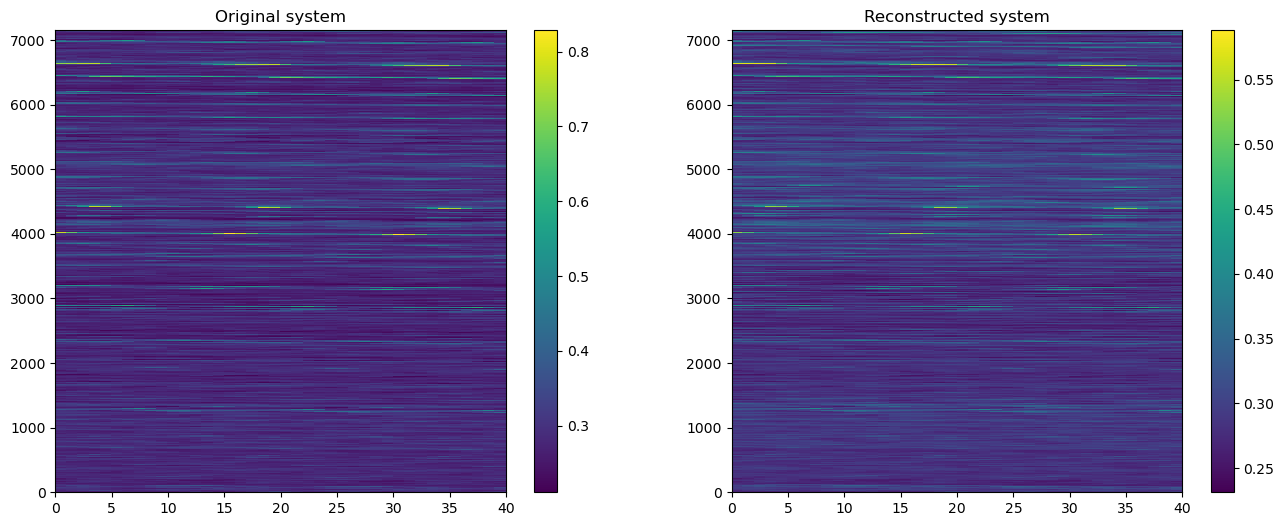

Errore MSE:
0.0006711644192884146
errore MAPE: 
5.416354785403485 %
errore MAE: 
0.016644471385300532
errore RMSE: 
(0.025906841167699597-4.381761463964888e-23j)
errore R2: 
0.06593078809925626


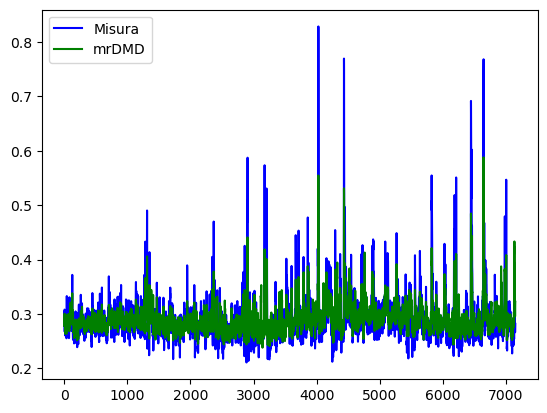

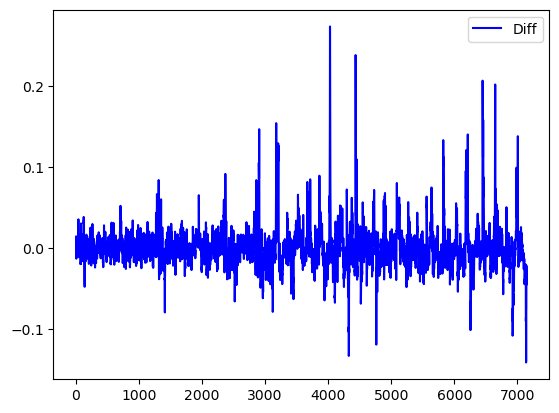

In [3]:




'''
la funzione hstack fa esattamente quello che si vede nell'esempio, i nodi sono messi in "ordine" (se non sbaglio
c'era un possibile dubbio sul cambio di bin-size ogni volta che cambiava livello), perchè vengono presi solamente i nodi 
del livello finale, quindi l'ordine con la quale vengono prelevati è FIFO (cioè i nodi che si trovano con il
livello maggiore in posizione con l'indice minore sono quelli che vengono inseriti prima nella matrice ricostruita)

In questo caso ad esempio con i dati di train vengono inseriti prima il nodo 9 ed il nodo 10, che sono i nodi che hanno il livello
massimo di ricorsione che si trovano con l'indice più piccolo tra i nodi con il livello massimo
'''

D_mrdmdc = np.zeros([row_tot, column_train], dtype = complex)

for i in range(0 , iteration_level(nodes) + 1):
    level_reconstruction = np.hstack(n.dato for n in nodes if n.level == i)
    level_rec_ridimensionato = dimensionamento(level_reconstruction, column_train)
    D_mrdmdc += level_rec_ridimensionato 
    D_mrdmdc = D_mrdmdc / 2
    x = D_mrdmdc.shape[0]
    y = D_mrdmdc.shape[1]
    x = np.linspace(0, x, x)
    y = np.linspace(0, y, y)
    #make_plot(D_mrdmdc.T, x=x, y=y, title='levels 0-' + str(i), figsize=(7.5, 5))
    #confronto(D_train, D_mrdmdc)
    if (level_reconstruction.shape[1] == D_train.shape[1]):
        break






plt.figure(figsize=(16, 6))

plt.subplot(121)
plt.title("Original system")
plt.pcolor(D_train.real.T)
plt.colorbar()

plt.subplot(122)
plt.title("Reconstructed system")
plt.pcolor(D_mrdmdc.real.T)
plt.colorbar()

plt.show()




def mean_squared_error(y_true, y_pred):
    """
    Funzione che calcola MSE.
    :param y_true: lista di numeri che rappresentano i valori reali
    :param y_pred: lista di numeri che rappresentano i valori predetti
    :restituisce: MSE
    """
    return np.mean(np.abs(np.array(y_pred) - np.array(y_true))**2)

def MAPE (Y_actual,Y_Predicted):   #MEAN ABSOLUTE PERCENTAGE ERROR
    mape = np.mean(np.abs((np.array(Y_actual) - np.array(Y_Predicted))/np.array(Y_actual)))*100
    return mape

def MAE(y_true, y_pred):     #MEAN ABSOLUTE ERROR
    mae_value = np.mean(np.abs(np.array(y_true) - np.array(y_pred)))
    return mae_value

def RMSE(y_true, y_pred):     #ROOT MEAN SQUARED ERROR
    rmse_value = np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))
    return rmse_value

from sklearn.metrics import r2_score
def R2(y_true, y_pred):
    r2_value = r2_score(np.array(y_true.real), np.array(y_pred.real))
    return r2_value



print("Errore MSE:")
print((mean_squared_error(D_mrdmdc.T,D_train.T)))
print ("errore MAPE: ")
print (MAPE(D_mrdmdc.T , D_train.T),"%")
print ("errore MAE: ")
print(MAE(D_mrdmdc.T , D_train.T))
print ("errore RMSE: ")
print(RMSE(D_mrdmdc.T , D_train.T))
print ("errore R2: ")
print(R2(D_mrdmdc.T , D_train.T))



plt.figure()
plt.plot(t_train, D_train.real[0,:], 'b', label='Misura')
plt.plot(t_train, D_mrdmdc.real[0,:], 'g', label='mrDMD')
plt.legend()
plt.show()

plt.figure()
error=np.array(D_train) - np.array(D_mrdmdc)
plt.plot(t_train, error.real[0,:], 'b', label='Diff')
plt.legend()
plt.show()



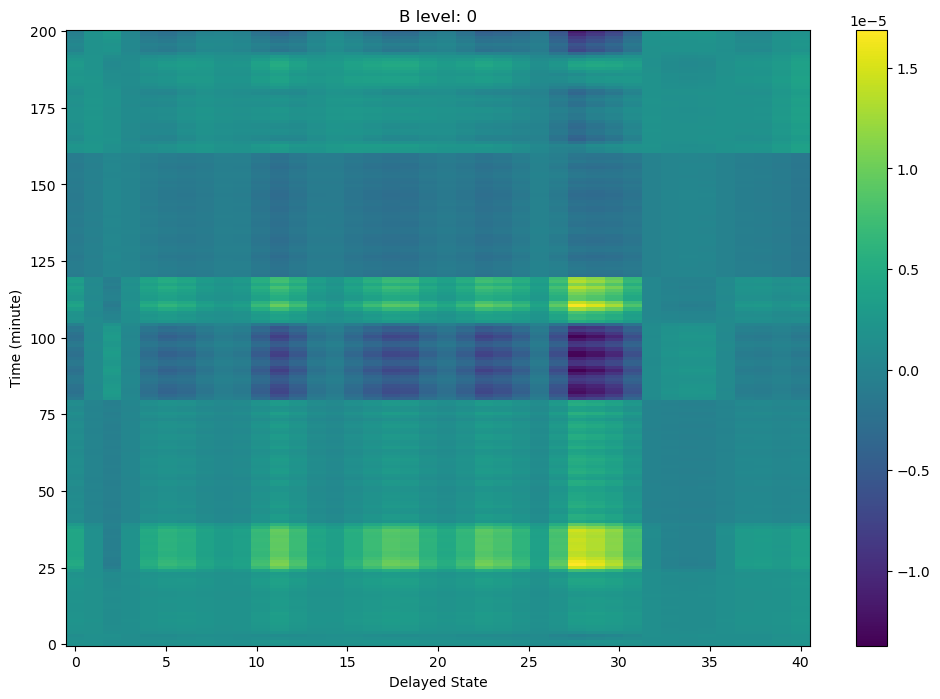

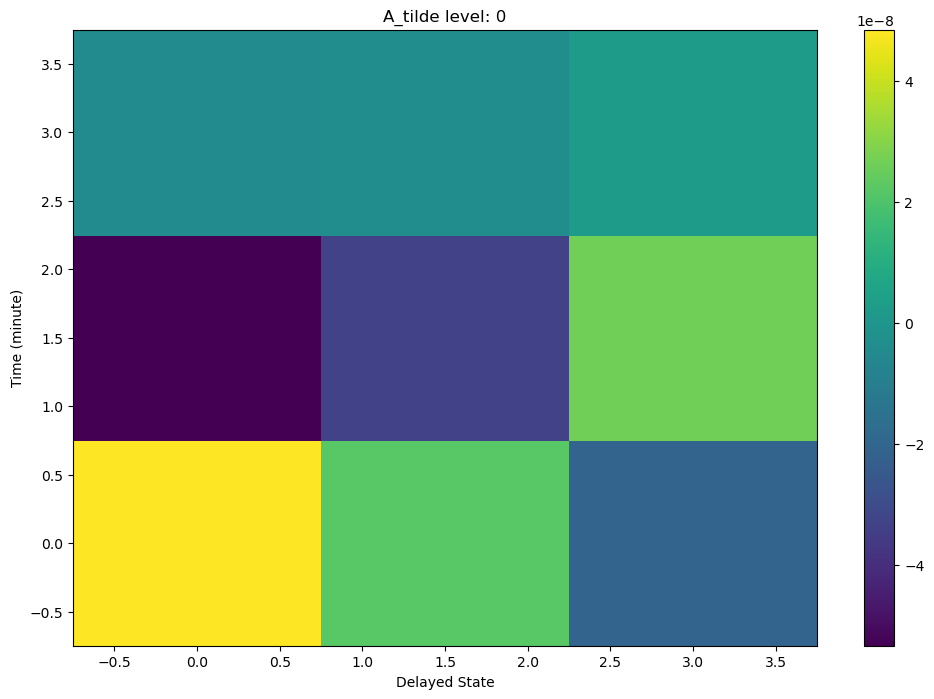

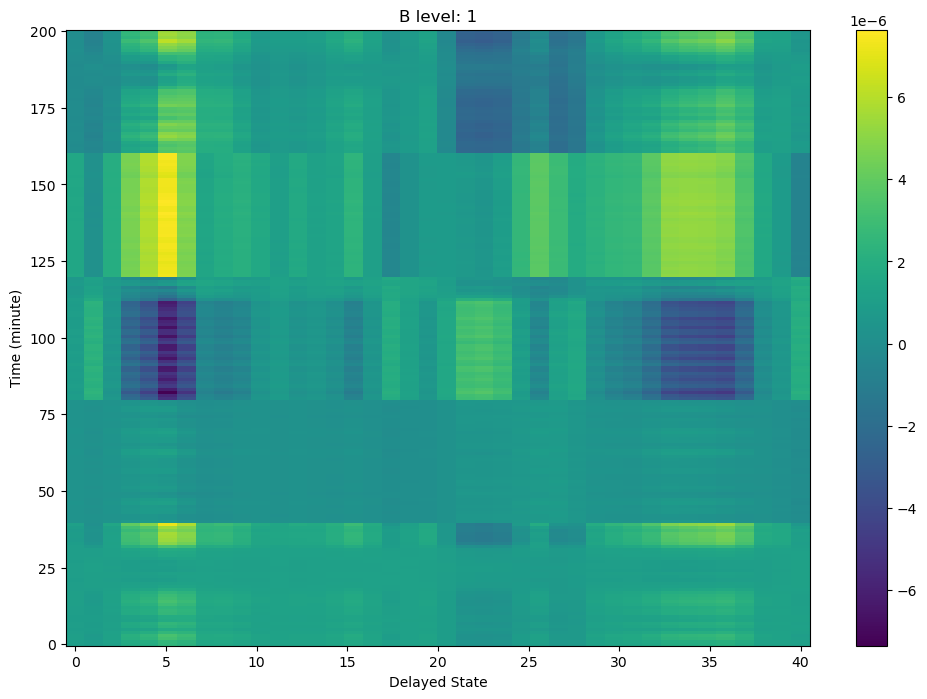

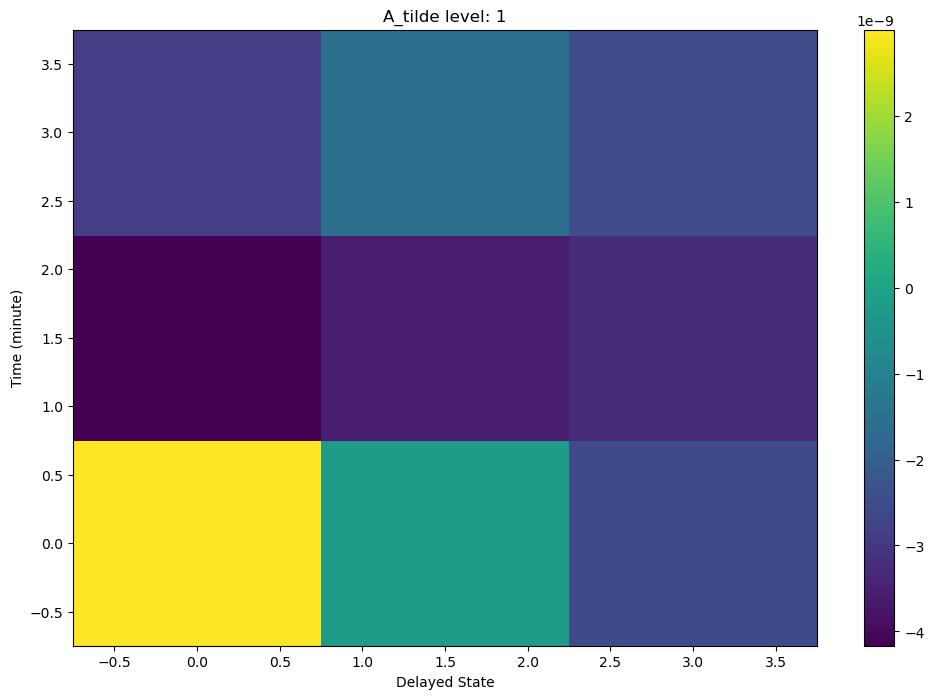

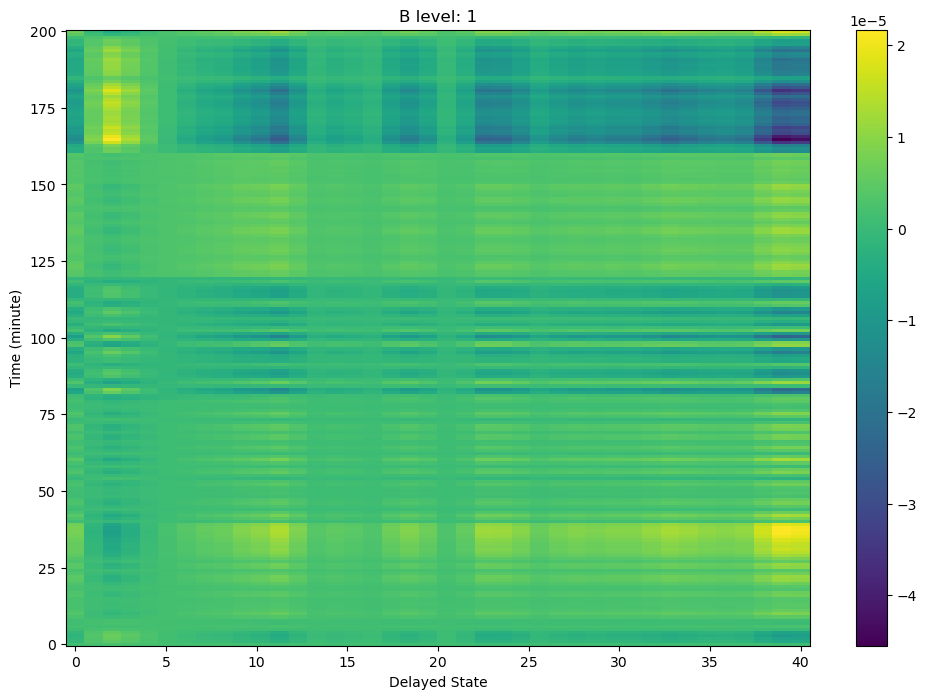

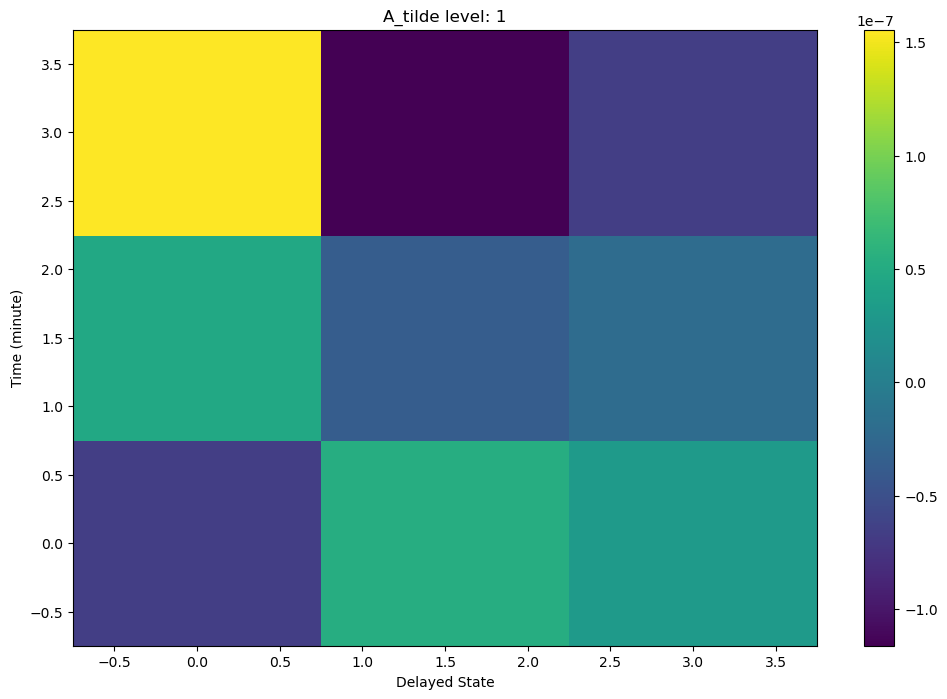

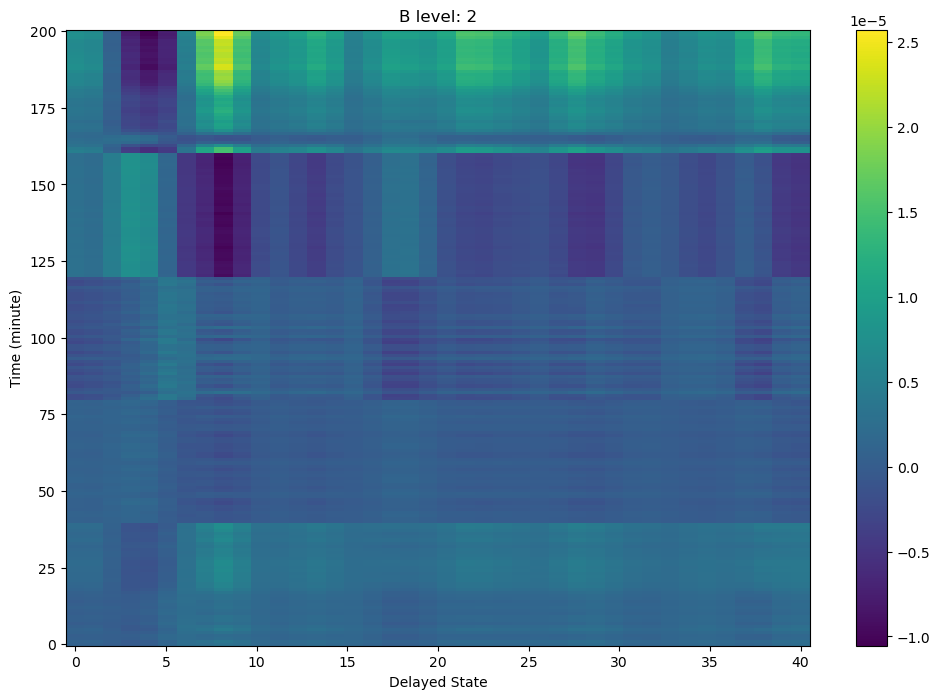

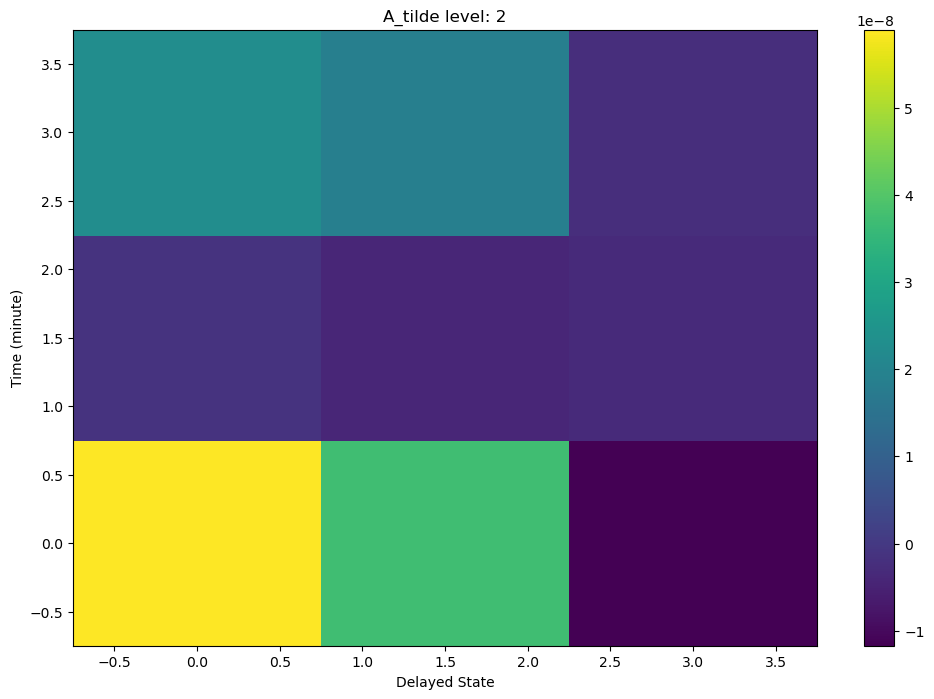

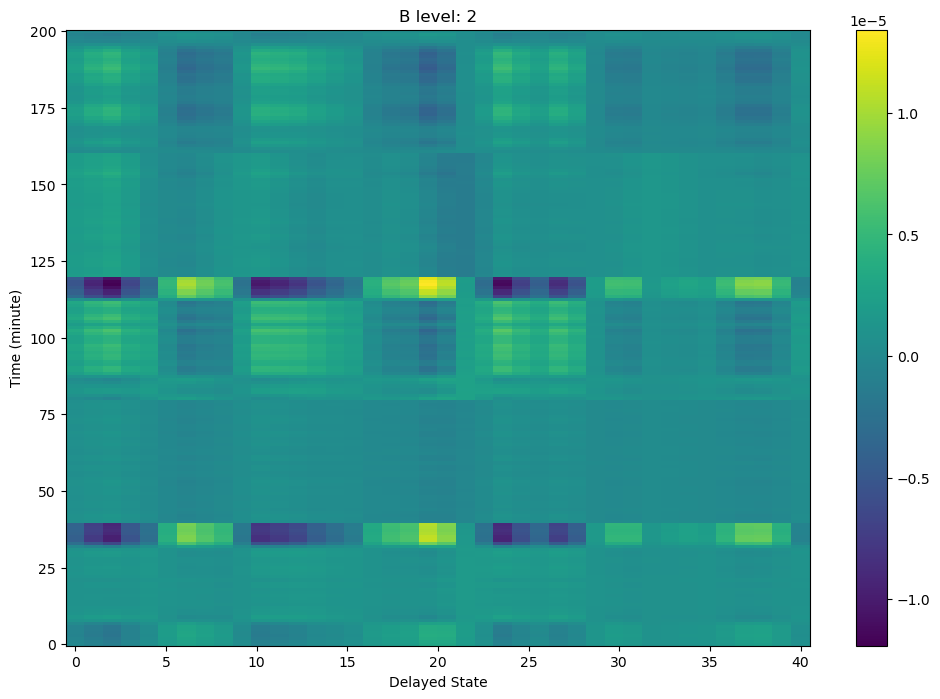

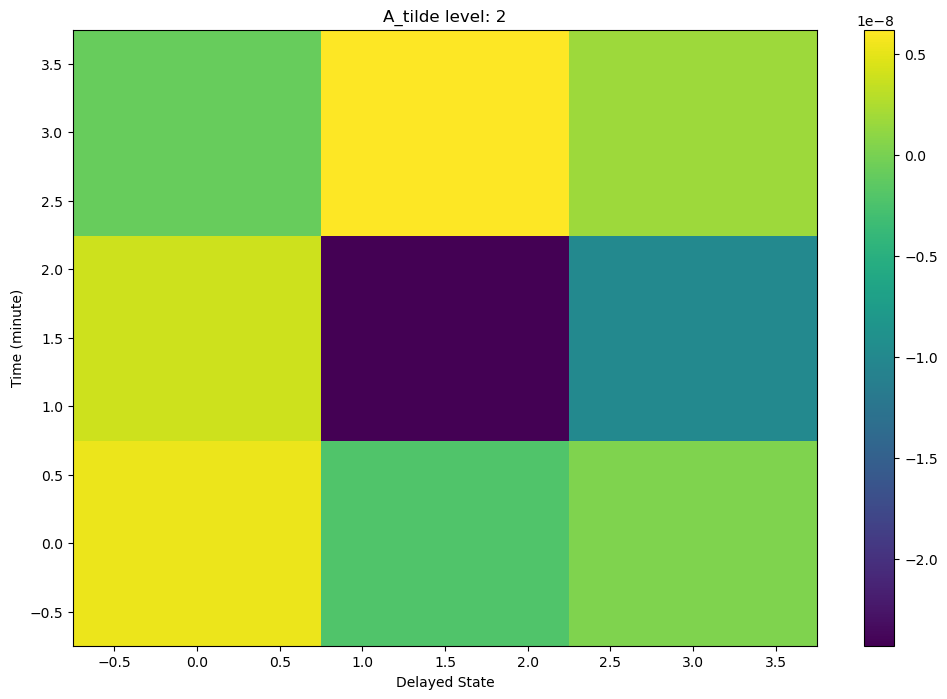

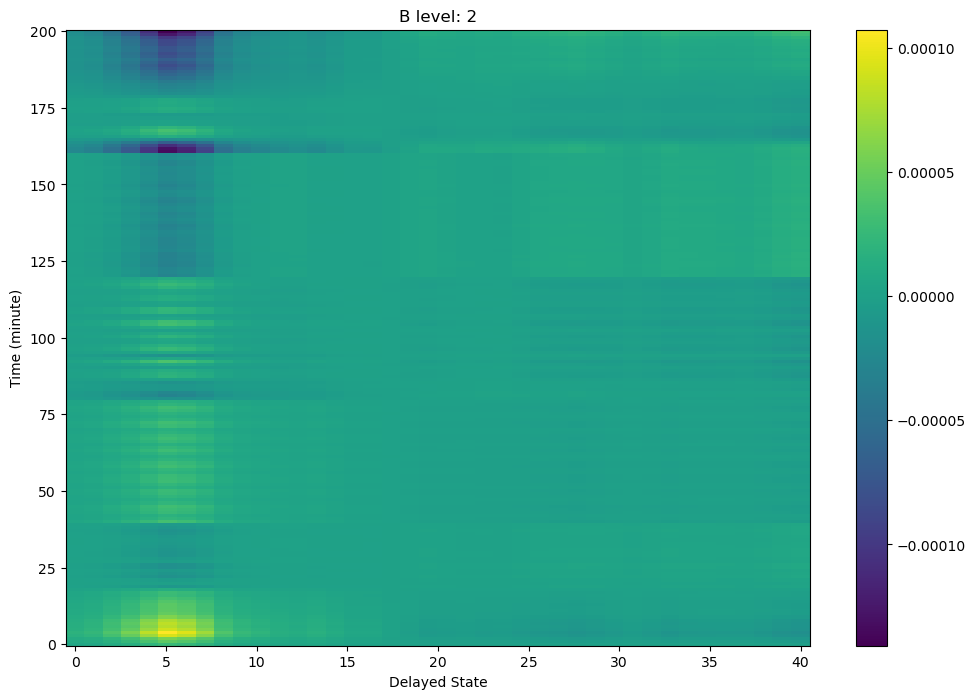

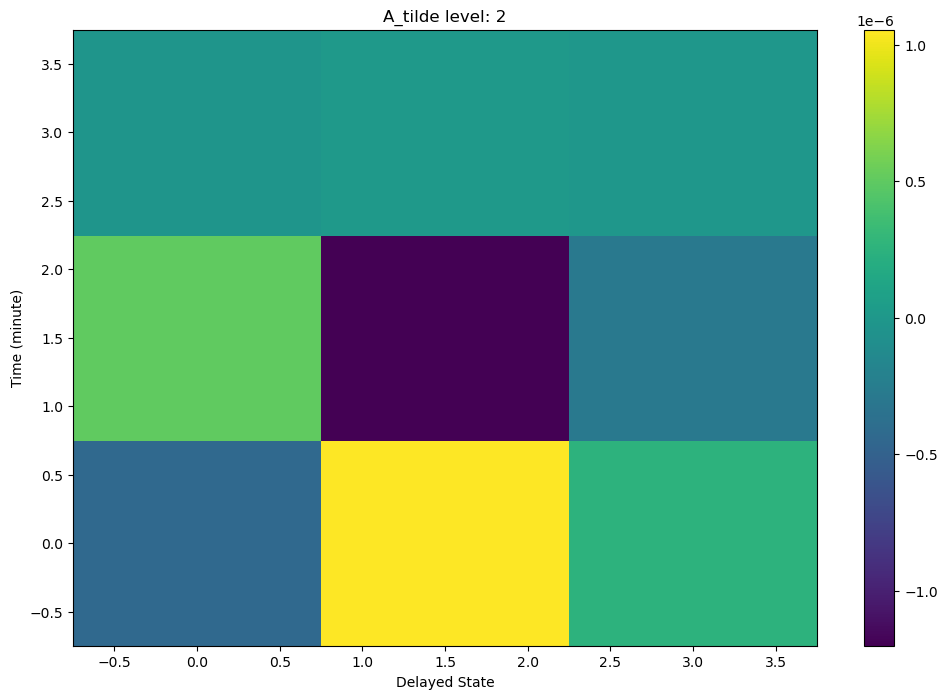

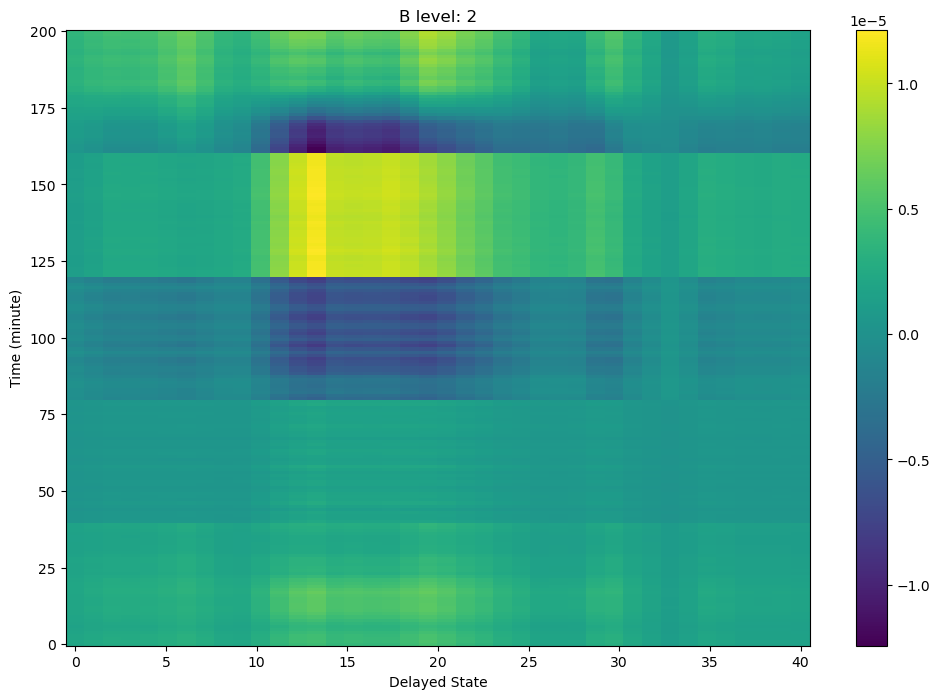

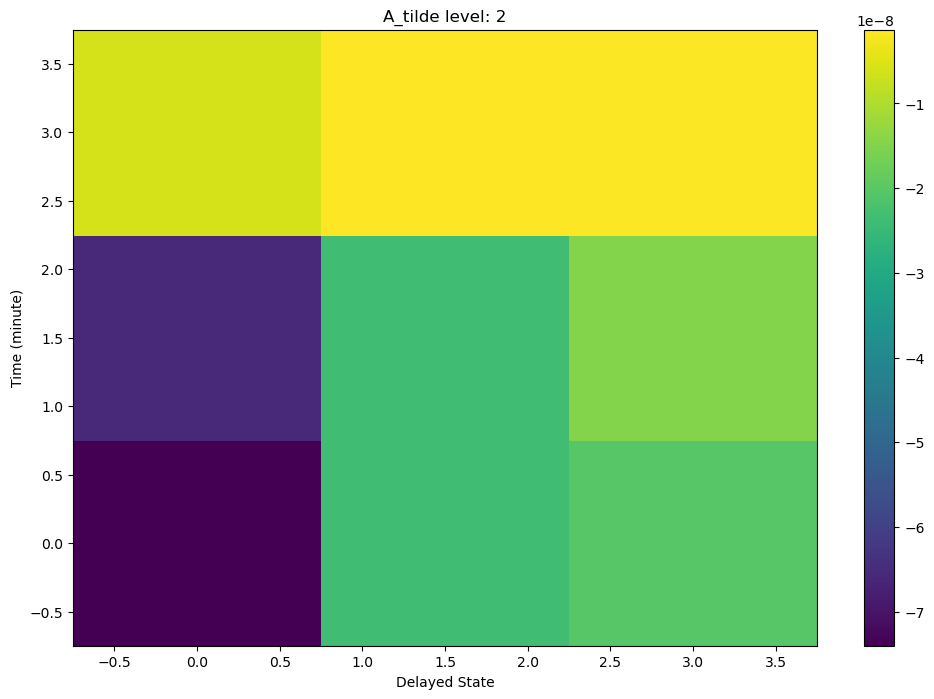

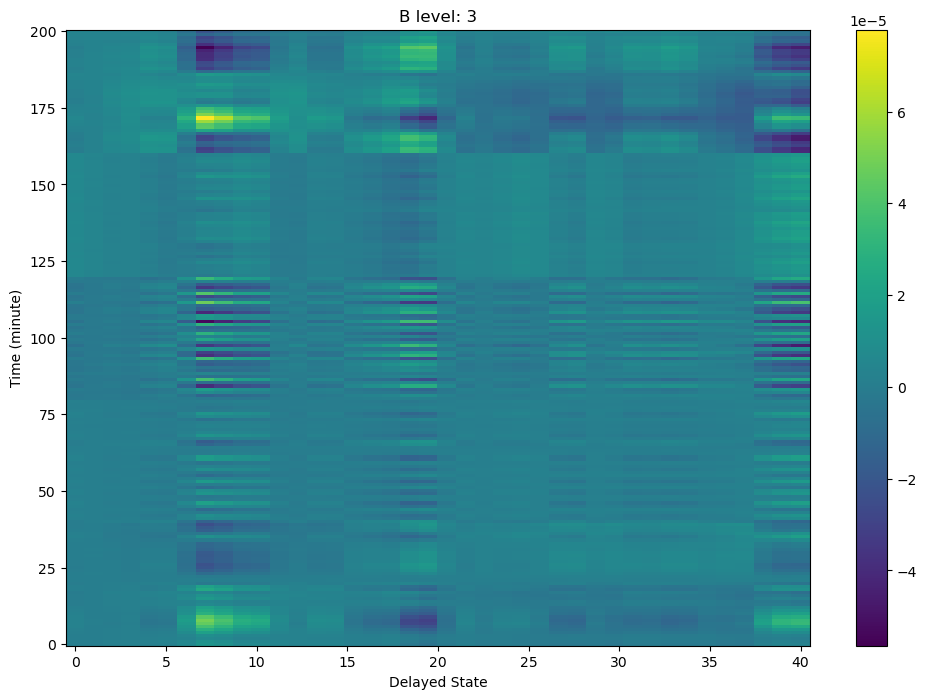

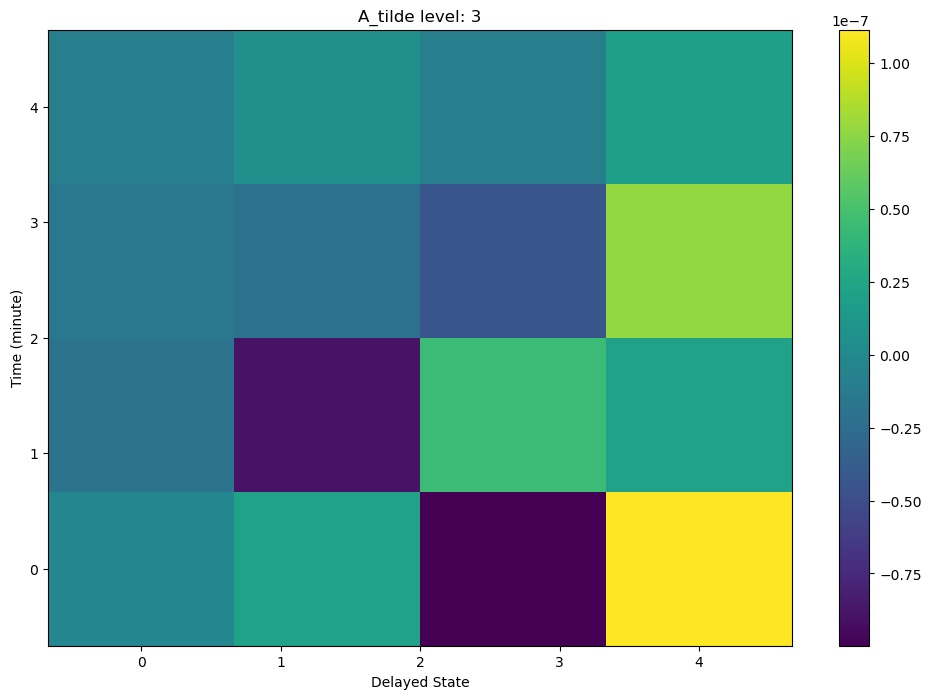

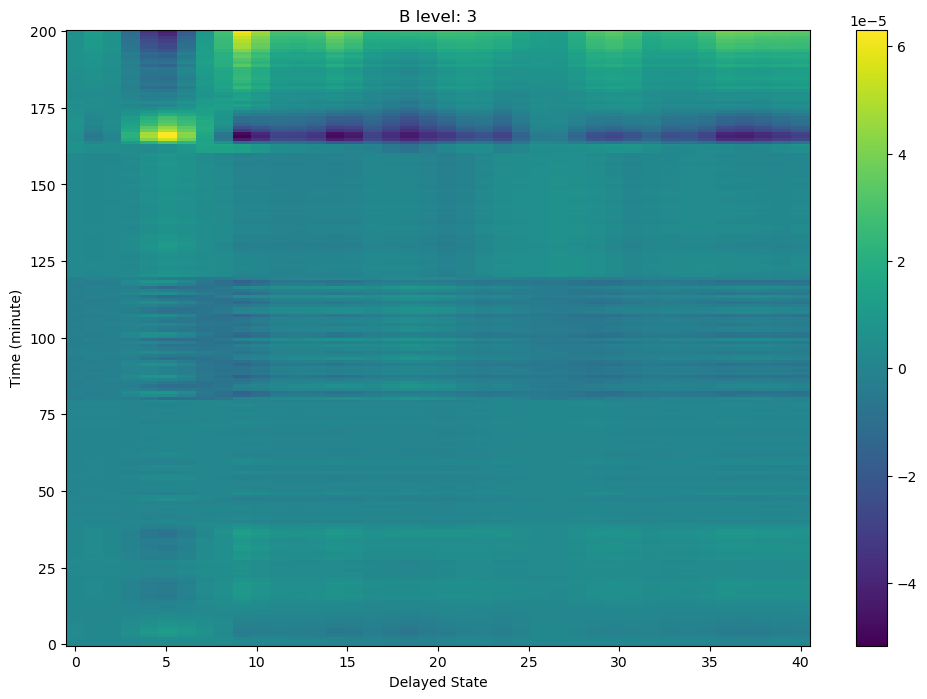

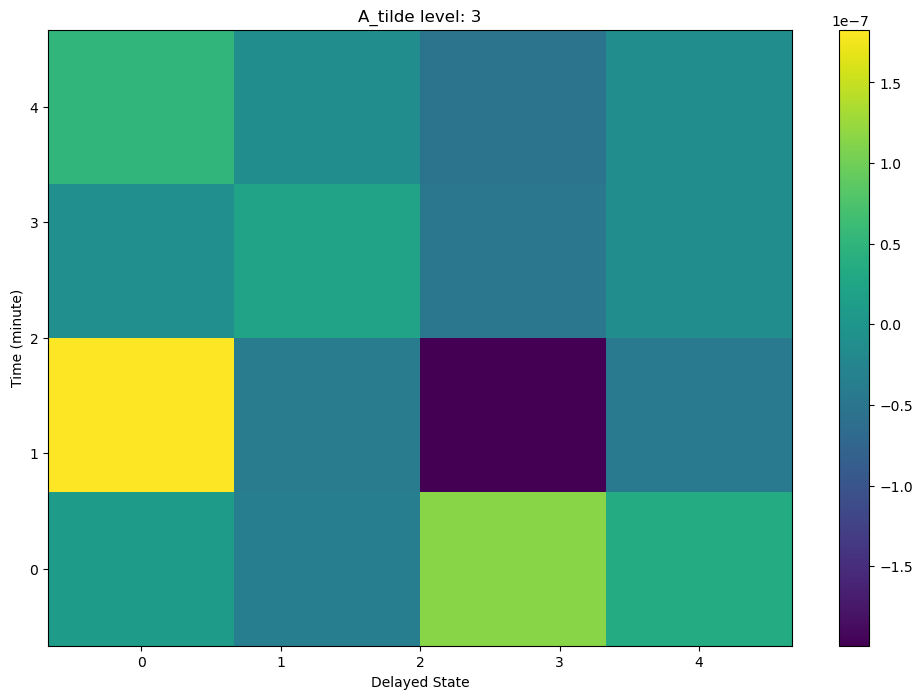

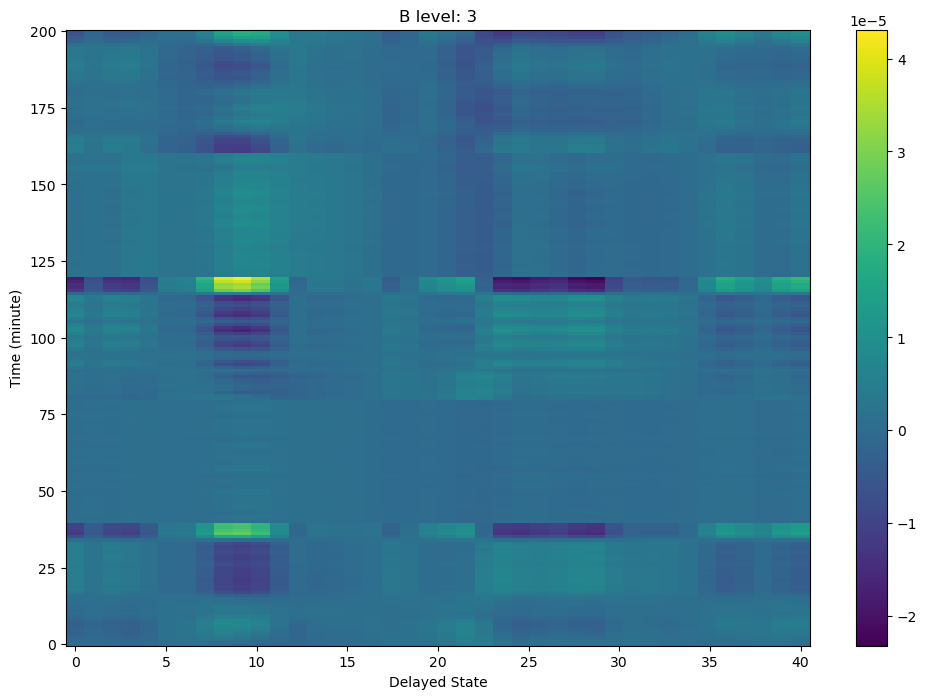

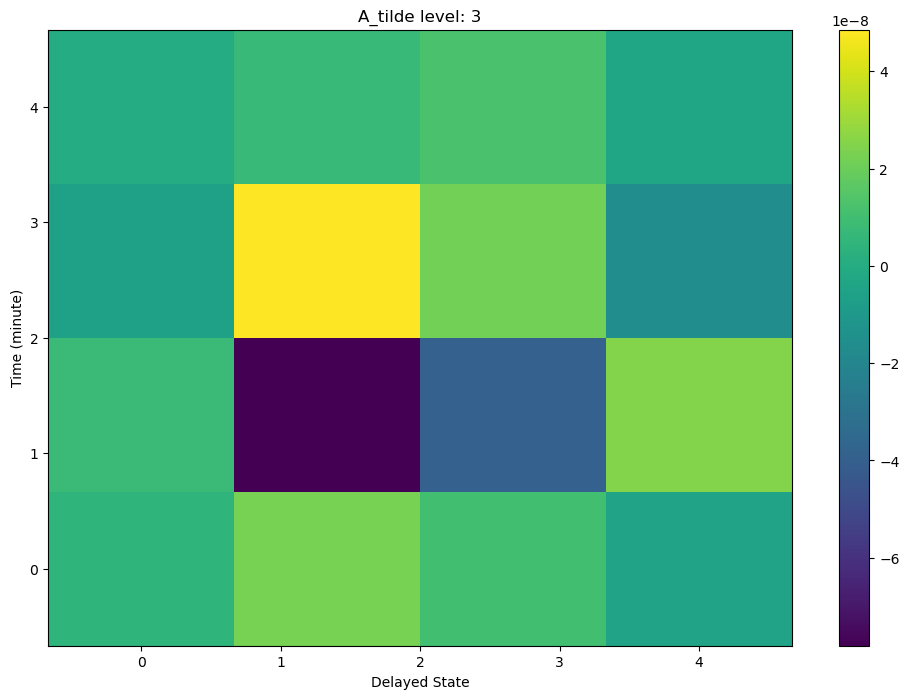

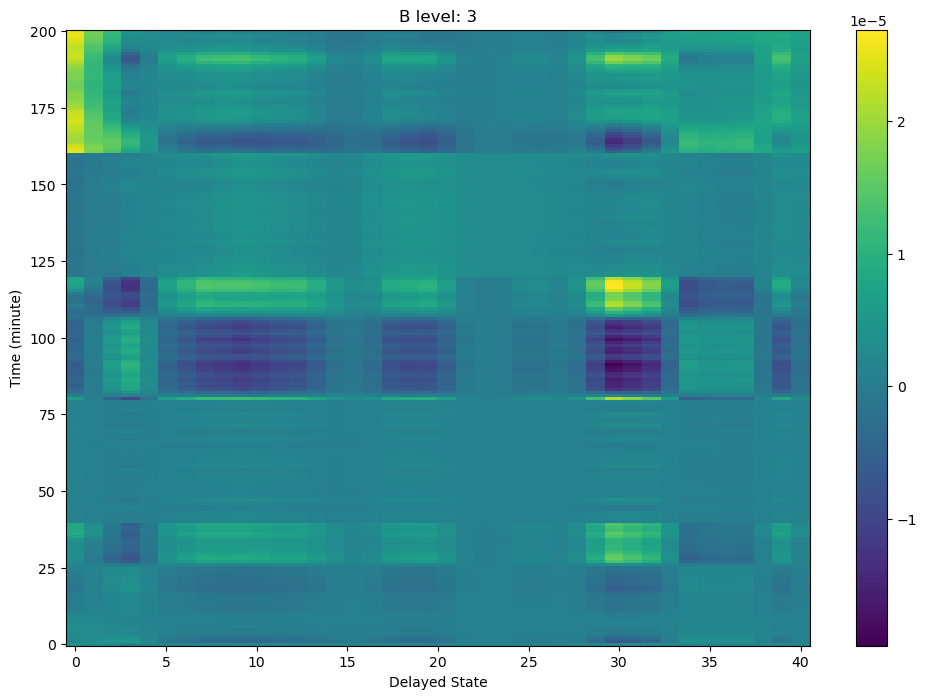

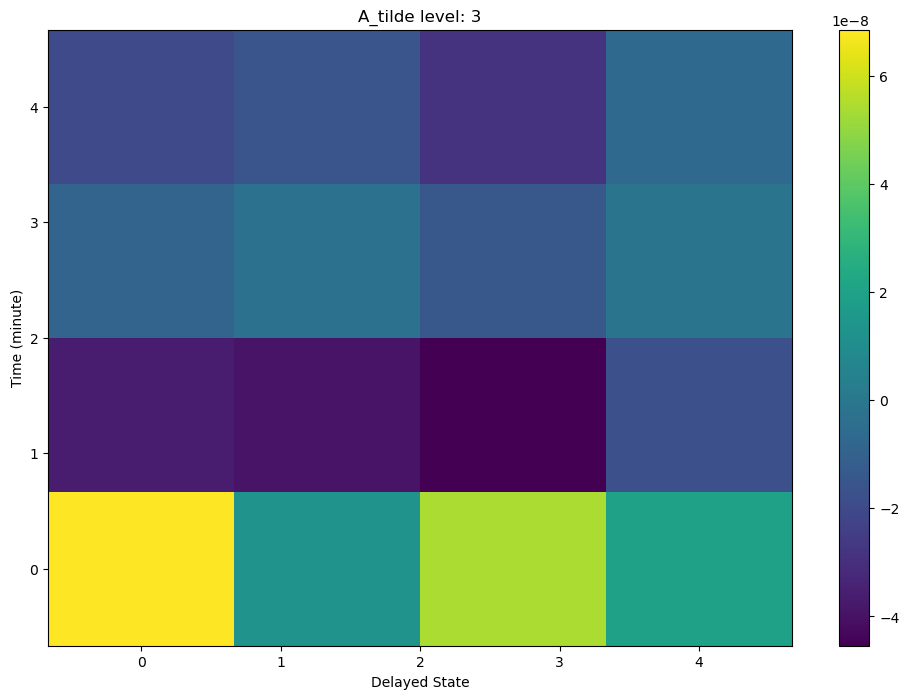

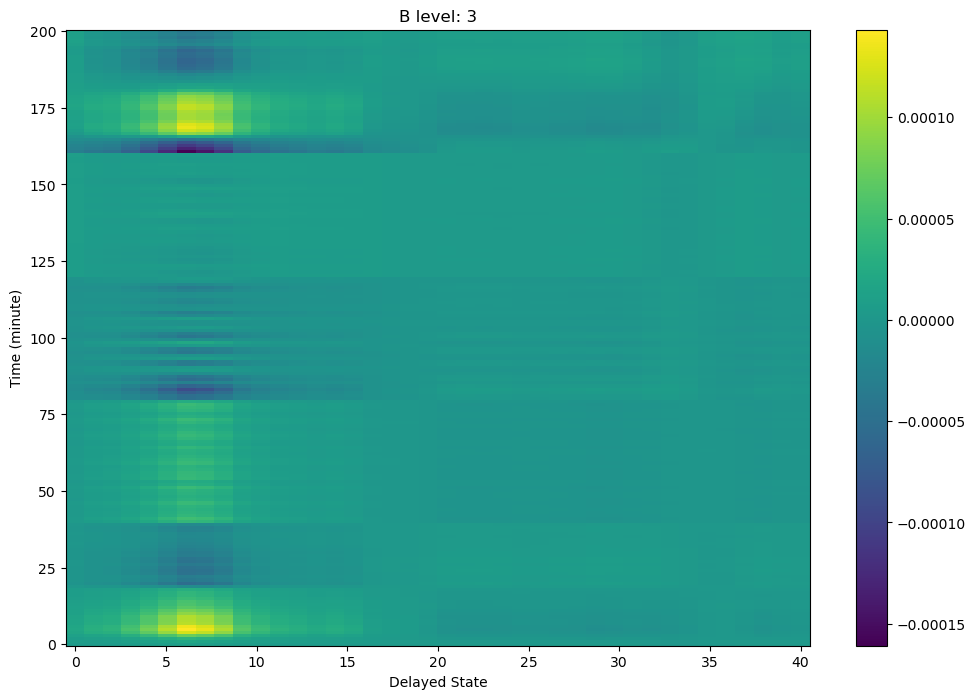

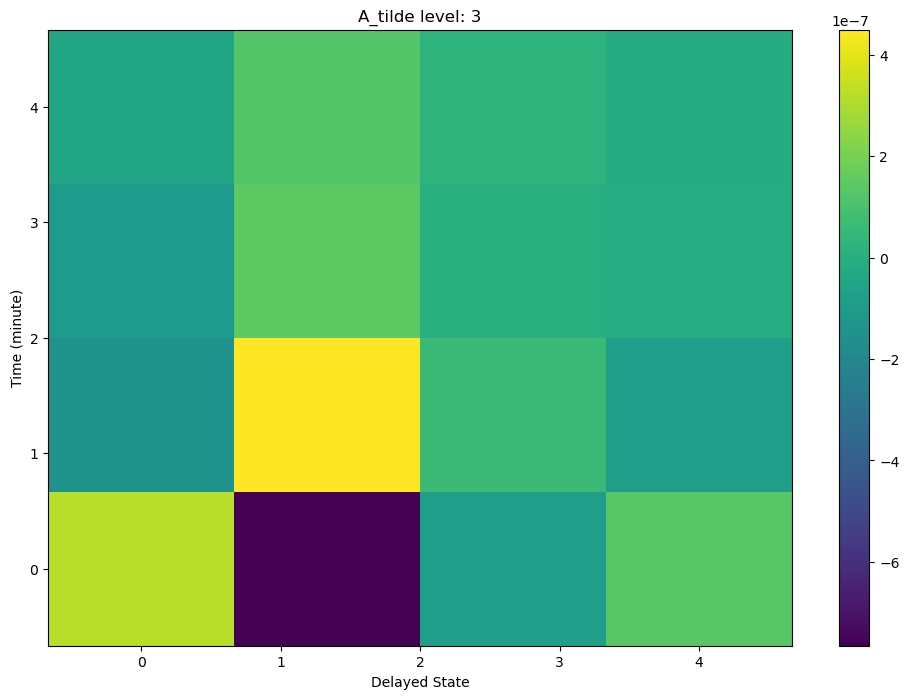

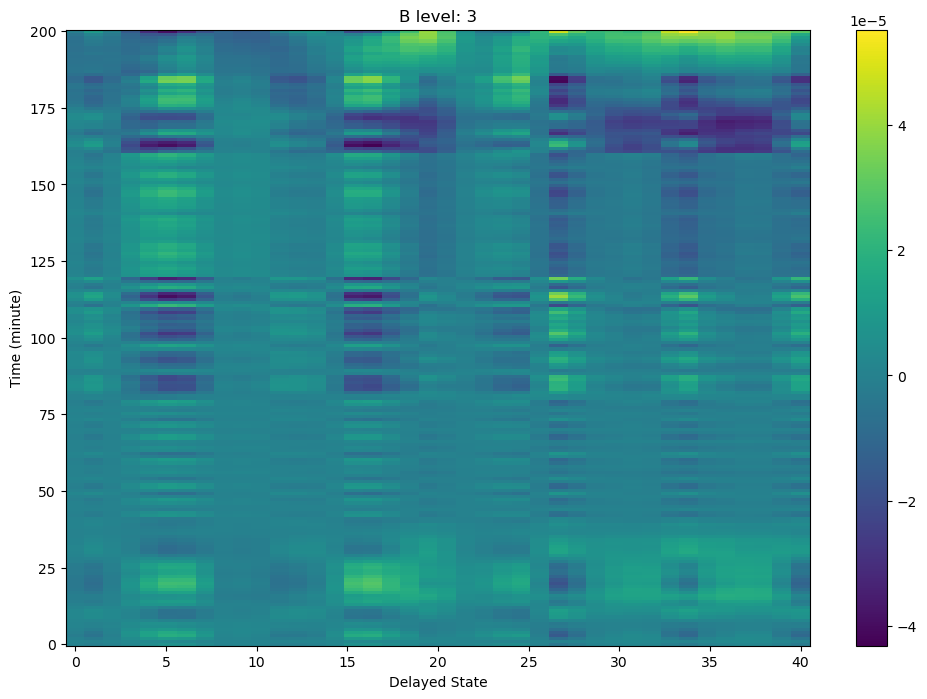

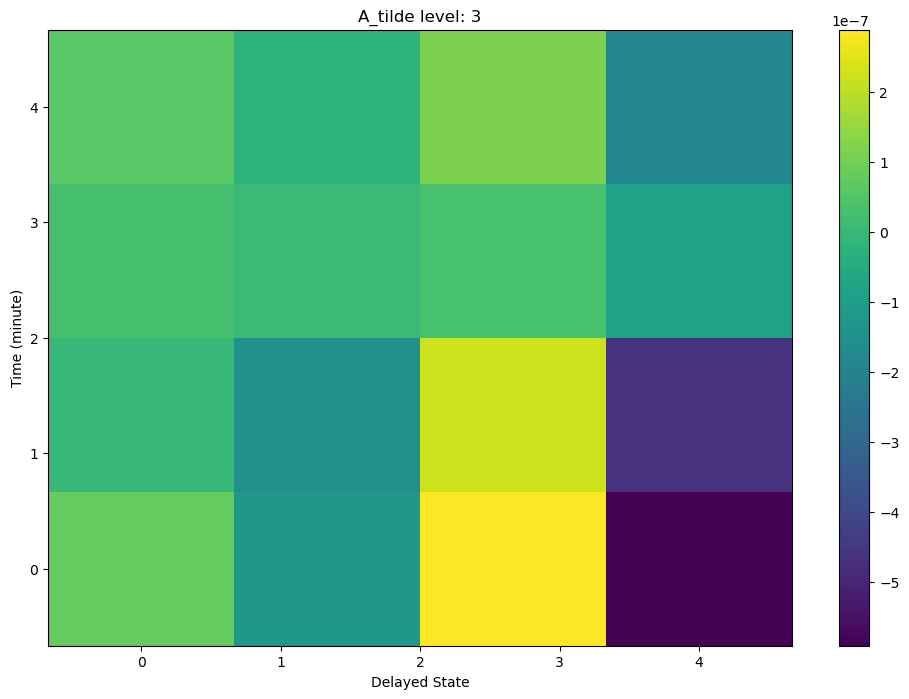

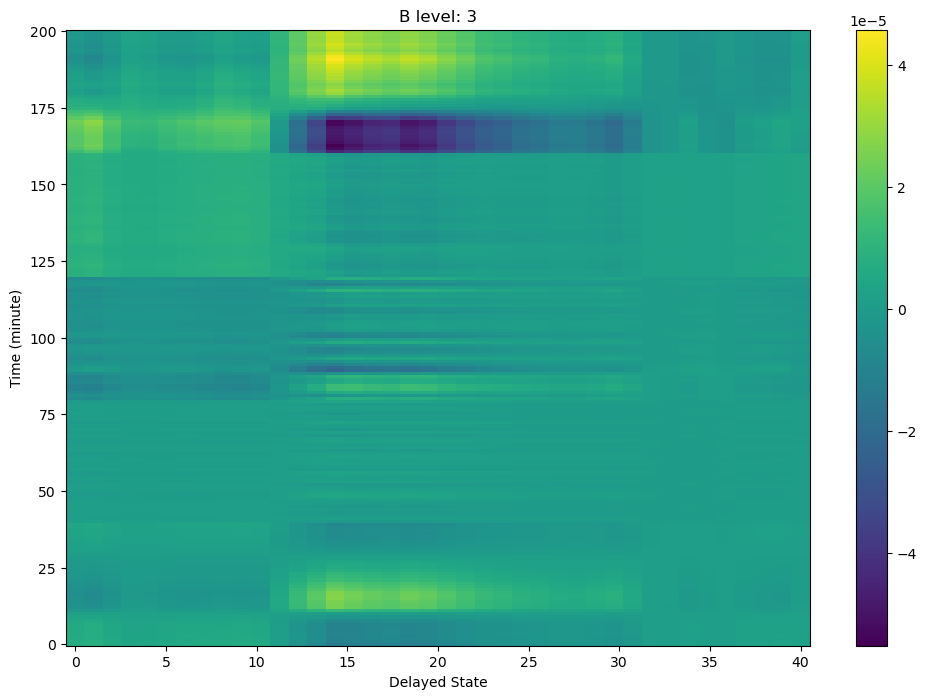

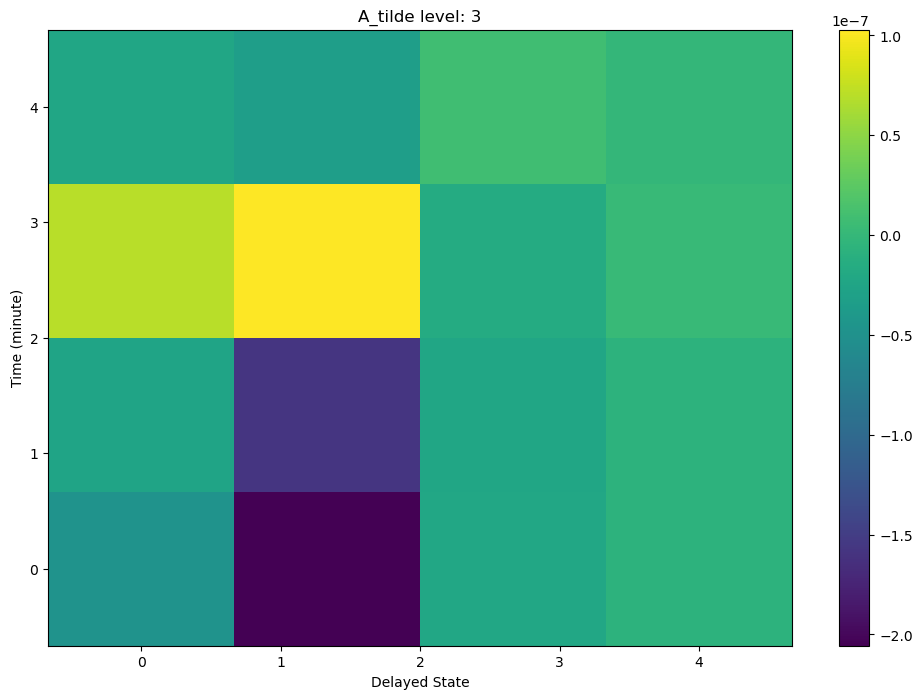

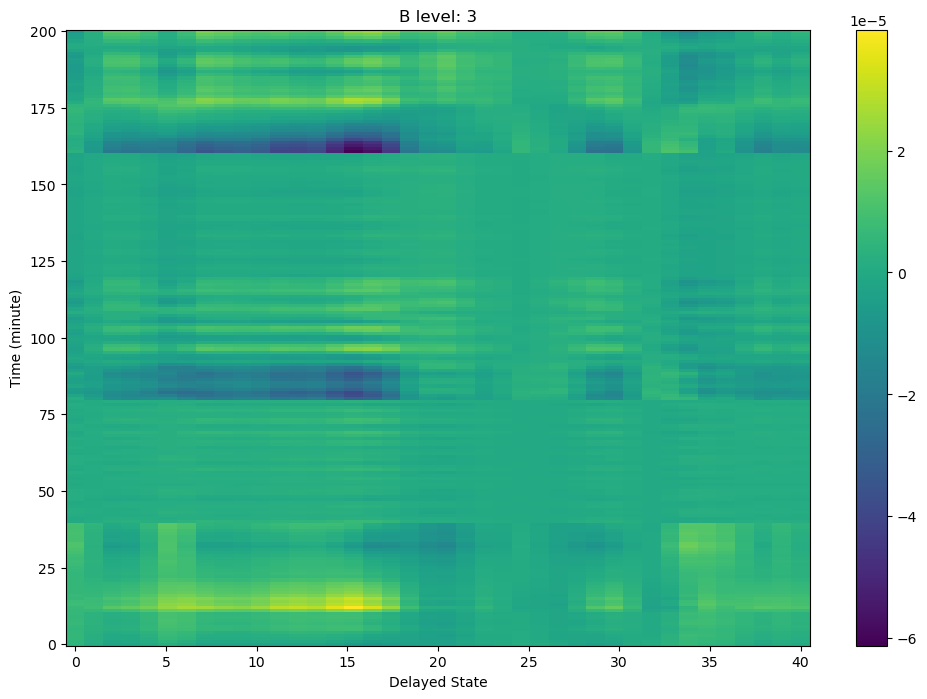

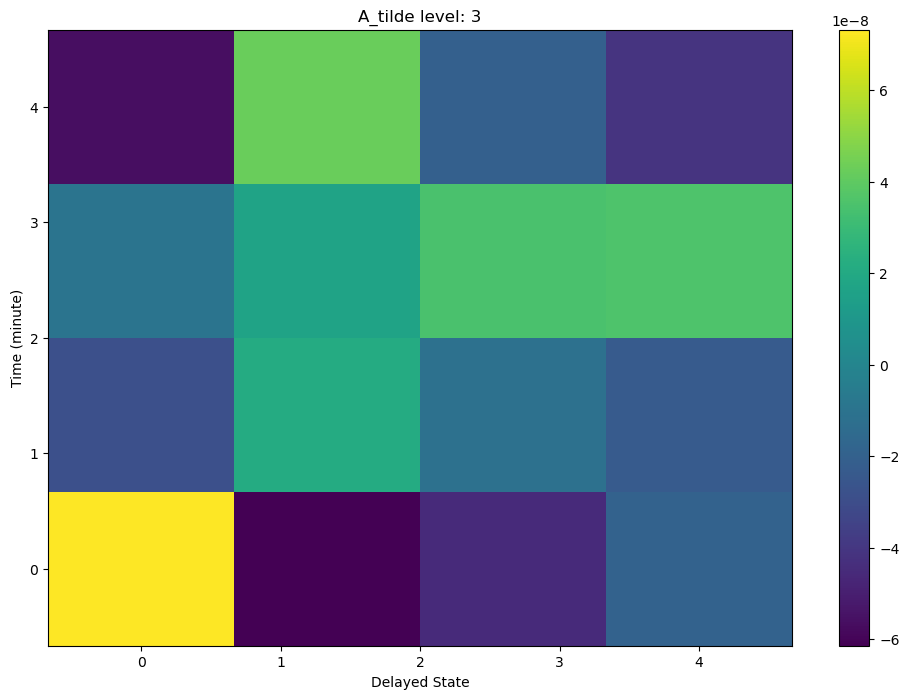

In [4]:


'''
vediamo di mostrare le B e le A_tilde per ogni livello mediate
for level in range (0, iteration_level(nodes) + 1):
    nodes_level_B = []
    nodes_level_A_tilde = []
    for n in nodes:
        if n.level == level:
            nodes_level_B.append(n.B)
            nodes_level_A_tilde.append(n._Atilde._Atilde)       #ho messo due volte _Atilde perchè la prima assegnazione è l'oggetto dmdunknownoperator

    level_B = sum(nodes_level_B)
    level_B = level_B / len(nodes_level_B)
    x = np.linspace(0, level_B.shape[0], level_B.shape[0])
    y = np.linspace(0, level_B.shape[1], level_B.shape[1])
    make_plot(level_B.T, x=x, y=y, title = '_B level:' + str(level))    #self.B

    #la parte dell'A_tilde funziona solo se si tronca (cioè svd_rank = 0)
    level_A_tilde = sum(nodes_level_A_tilde)
    level_A_tilde = level_A_tilde / len(nodes_level_A_tilde)
    x = np.linspace(0, level_A_tilde.shape[0], level_A_tilde.shape[0])
    y = np.linspace(0, level_A_tilde.shape[1], level_A_tilde.shape[1])
    make_plot(level_A_tilde, x=x, y=y, title = 'A_tilde level:' + str(level))   #self._Atilde
    '''



'''vediamo di mostrare le A_tilde e le B dei nodi

le A_tilde e le B cambiano a seconda del svd_rank che scegliamo'''
for level in range (0, 4):
    for node in nodes:
        if node.level == level:
            x = np.linspace(0, node.B.shape[0], node.B.shape[0])
            y = np.linspace(0, node.B.shape[1], node.B.shape[1])
            make_plot(node.B.T, x=x, y=y, title='B level: ' + str(level))

            x = np.linspace(0, node._Atilde._Atilde.shape[0], node._Atilde._Atilde.shape[0])
            y = np.linspace(0, node._Atilde._Atilde.shape[1], node._Atilde._Atilde.shape[1])
            make_plot(node._Atilde._Atilde.T, x=x, y=y, title='A_tilde level: ' + str(level))




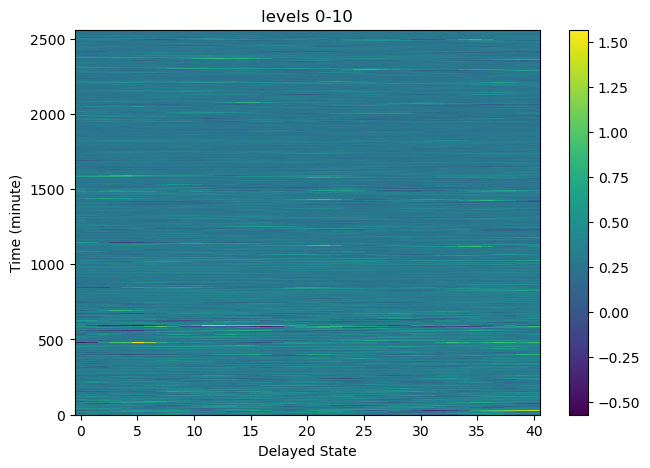

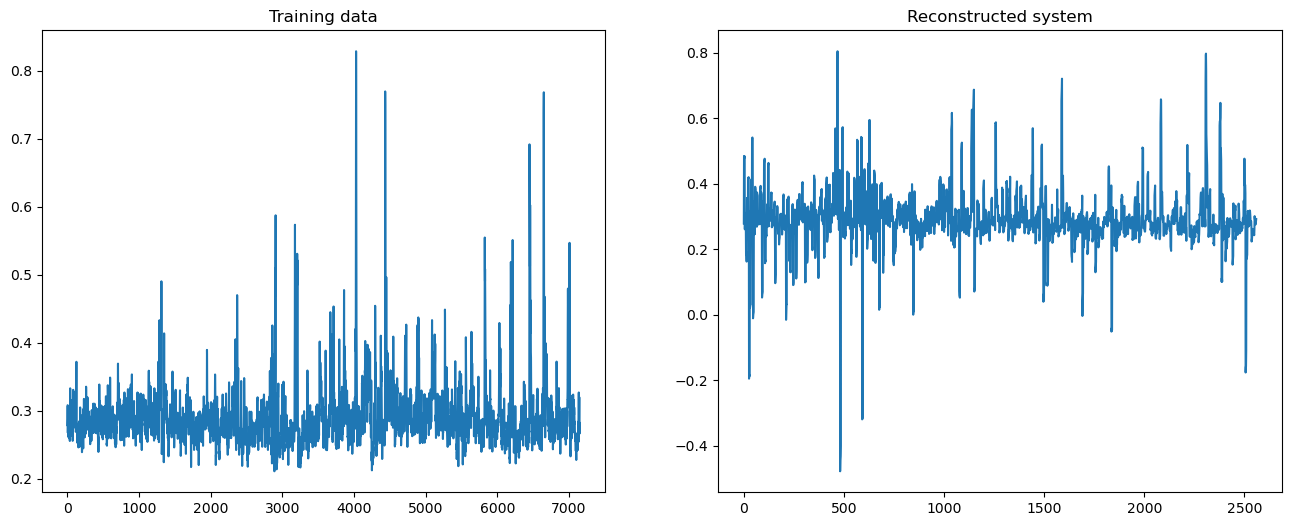

In [5]:


'''Facciamo una funzione per controllare qual è il bin_size più vicino alla U_test'''

def choose_bin(U_test, nodes):
    for i in range(0, len(nodes)):
        if (nodes[i].bin_size >= U_test.shape[1]):
            node = nodes[i]
    return node

'''A questo punto vado a campionare la U_test e la passo a reconstructed_data'''

dmdc_reconstruct = choose_bin(U_test, nodes)
U_test = dimensionamento(U_test, dmdc_reconstruct.bin_size)
U_test_sub = U_test[:,::dmdc_reconstruct.step]

nodes_reconstruct = []
for node in nodes:
    if node.level == dmdc_reconstruct.level:
        nodes_reconstruct.append(node)

#rec = np.zeros([row_tot, column_train], dtype = complex)
insieme_reconstruct = []

for node in nodes_reconstruct:
    reconstructed_data_test = node.reconstructed_data(U_test_sub[:,1:])
    insieme_reconstruct.append(reconstructed_data_test)      #append function add the data passed to array

reconstruct = np.hstack(insieme_reconstruct)

#reconstruct = dimensionamento(reconstruct, column_train)
x = reconstruct.shape[0]
y = reconstruct.shape[1]   
x = np.linspace(0, x, x)
y = np.linspace(0, y, y)
make_plot(reconstruct.T, x=x, y=y, title='levels 0-' + str(i), figsize=(7.5, 5))
confronto(D_train, reconstruct)



